# Figures 5 and 7

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from xhistogram.xarray import histogram


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers=48,memory_limit='1400gb')

### Defining functions

In [3]:
def shelf_mask_isobath(var, contour_depth, resolution, output_mask=False):
    '''
    Masks variales by the region polewards of a given isobath
    '''
    
    ds_contour = xr.open_dataset(
        '/home/142/cs6673/work/mom6_comparison/Antarctic_slope_contours/' +
        'Antarctic_slope_contour_' + str(contour_depth) + 'm_MOM6_' +
        resolution + 'deg.nc')
    
    shelf_mask = ds_contour.contour_masked_above.sel(yh=slice(var.yh[0], var.yh[-1]))
    yh = ds_contour.yh.sel(yh=slice(var.yh[0], var.yh[-1]))
    xh = ds_contour.xh
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask = shelf_mask.where(shelf_mask == 0)+1
    shelf_mask = shelf_mask.where(shelf_mask == 1, 0)
    
    # multiply the variable with the mask
    masked_var = var * shelf_mask
    
    if output_mask == True:
        return masked_var, shelf_mask
    else:
        return masked_var

In [4]:
def shelf_mask_isobath_MOM5(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map  = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map  = xr.DataArray(shelf_map,  coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask

    return masked_var, shelf_map

In [5]:
#defining multiline plot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

### Getting mean salinity and density on the shelf

#### MOM6

In [6]:
#importing SSH, DEPTH salinity and Mass transport across Isobath along the shelf
direct_db='/home/156/wf4500/databases/access/DIRECT_DSW.db'

direct_session = cc.database.create_session(direct_db)
session = cc.database.create_session()

exp_P1m = 'panan01_1mtop_daily'
exp_P5m = 'panan01_5mtop_daily'
exp_P1m_direct = 'mom6-panan'


In [7]:
#lets import the data expressly to see if we can actually see the same salinity fields change
S5m_6months = xr.open_mfdataset('/scratch/oz91/wf4500/panan01_5mtop/wf4500/mom6/archive/mom6-panan/output00*/*.ocean_month_z.nc').so.isel(time=slice(0,6)).load()
S1m_6months = xr.open_mfdataset('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output00*/*.ocean_month_z.nc').so.isel(time=slice(0,6)).load()
S1m_winds_6months = xr.open_mfdataset('/g/data/v45/wf4500/DSW_collaborative/panan01_DIRECT_STRESS_rerun/mom6-panan/archive/output00*/*.ocean_month_z.nc').so.isel(time=slice(0,6)).load()

#rhopot2 σ2
σ2_5m_6months = xr.open_mfdataset('/scratch/oz91/wf4500/panan01_5mtop/wf4500/mom6/archive/mom6-panan/output00*/*.ocean_month_z.nc').rhopot2.isel(time=slice(0,6)).load()
σ2_1m_6months = xr.open_mfdataset('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output00*/*.ocean_month_z.nc').rhopot2.isel(time=slice(0,6)).load()
σ2_1m_winds_6months = xr.open_mfdataset('/g/data/v45/wf4500/DSW_collaborative/panan01_DIRECT_STRESS_rerun/mom6-panan/archive/output00*/*.ocean_month_z.nc').rhopot2.isel(time=slice(0,6)).load()



#vol
vol_5m_6months = xr.open_mfdataset('/scratch/oz91/wf4500/panan01_5mtop/wf4500/mom6/archive/mom6-panan/output00*/*.ocean_month_z.nc').volcello.isel(time=slice(0,6)).load()
vol_1m_6months = xr.open_mfdataset('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output00*/*.ocean_month_z.nc').volcello.isel(time=slice(0,6)).load()
vol_1m_winds_6months = xr.open_mfdataset('/g/data/v45/wf4500/DSW_collaborative/panan01_DIRECT_STRESS_rerun/mom6-panan/archive/output00*/*.ocean_month_z.nc').volcello.isel(time=slice(0,6)).load()



In [8]:
S1m_6months_into5 = S5m_6months.copy()
S1m_6months_into5[:,0,:,:] = S1m_6months[:,0:4,:,:].weighted(vol_1m_6months[:,0:4,:,:].fillna(0)).mean('z_l')
S1m_6months_into5[:,1:,:,:]= S1m_6months[:,4:,:,:].values

S1m_winds_6months_into5 = S5m_6months.copy()
S1m_winds_6months_into5[:,0,:,:] = S1m_winds_6months[:,0:4,:,:].weighted(vol_1m_winds_6months[:,0:4,:,:].fillna(0)).mean('z_l')
S1m_winds_6months_into5[:,1:,:,:]= S1m_winds_6months[:,4:,:,:].values



σ2_1m_6months_into5 = σ2_5m_6months.copy()
σ2_1m_6months_into5[:,0,:,:] = σ2_1m_6months[:,0:4,:,:].weighted(vol_1m_6months[:,0:4,:,:].fillna(0)).mean('z_l')
σ2_1m_6months_into5[:,1:,:,:]= σ2_1m_6months[:,4:,:,:].values

σ2_1m_winds_6months_into5 = σ2_5m_6months.copy()
σ2_1m_winds_6months_into5[:,0,:,:] = σ2_1m_winds_6months[:,0:4,:,:].weighted(vol_1m_winds_6months[:,0:4,:,:].fillna(0)).mean('z_l')
σ2_1m_winds_6months_into5[:,1:,:,:]= σ2_1m_winds_6months[:,4:,:,:].values

In [9]:
deltaS_5m_1m = (S5m_6months - S1m_6months).sel(z_l=5.8,method='nearest')
deltaS_1mwinds_1m = (S1m_winds_6months - S1m_6months).sel(z_l=5.8,method='nearest')
deltaS_5m_1mwinds = (S5m_6months - S1m_winds_6months).sel(z_l=5.8,method='nearest')

In [10]:
#lets import the data expressly to see if we can actually see the same salinity fields change
MOM5_S5m_6months = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath_5mtop/output00*/ocean/ocean.nc').salt.isel(time=slice(0,6)).load()
MOM5_S1m_6months = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output00*/ocean/ocean.nc').salt.isel(time=slice(0,6)).load()


MOM5_σ0_5m_6months = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath_5mtop/output00*/ocean/ocean.nc').pot_rho_0.isel(time=slice(0,6)).load()
MOM5_σ0_1m_6months = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output00*/ocean/ocean.nc').pot_rho_0.isel(time=slice(0,6)).load()

MOM5_dzt_5m_6months = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath_5mtop/output00*/ocean/ocean.nc').dzt.isel(time=slice(0,6)).load()
MOM5_dzt_1m_6months = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output00*/ocean/ocean.nc').dzt.isel(time=slice(0,6)).load()



In [11]:
MOM5_S1m_6months_into5 = MOM5_S5m_6months.copy()
MOM5_S1m_6months_into5[:,0,:,:] = MOM5_S1m_6months[:,0:4,:,:].weighted(MOM5_dzt_1m_6months[:,0:4,:,:].fillna(0)).mean('st_ocean')
MOM5_S1m_6months_into5[:,1:,:,:]= MOM5_S1m_6months[:,4:,:,:].values

In [12]:
MOM5_σ0_1m_6months_into5 = MOM5_σ0_5m_6months.copy()
MOM5_σ0_1m_6months_into5[:,0,:,:] = MOM5_σ0_1m_6months[:,0:4,:,:].weighted(MOM5_dzt_1m_6months[:,0:4,:,:].fillna(0)).mean('st_ocean')
MOM5_σ0_1m_6months_into5[:,1:,:,:]= MOM5_σ0_1m_6months[:,4:,:,:].values

In [13]:
MOM5_deltaS_5m_1m = (MOM5_S5m_6months - MOM5_S1m_6months_into5).sel(st_ocean=5.8,method='nearest')

In [14]:
areacello = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'areacello',session,n=1)
areacello_shelf, shelf_mask_MOM6 = shelf_mask_isobath(areacello, 1000, '01', output_mask=True)

area_t = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'area_t',session,n=1)
area_t_shelf, shelf_mask_MOM5 = shelf_mask_isobath_MOM5(area_t)

In [15]:
vol_5m_6months_shelf, shelf_mask_MOM6 = shelf_mask_isobath(vol_5m_6months, 1000, '01', output_mask=True)
vol_5m_6months_shelf.load()

<xarray.DataArray (time: 6, z_l: 72, yh: 533, xh: 3600)> Size: 3GB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.0 -78.95 -78.91 ... -55.18 -55.12 -55.07
  * z_l      (z_l) float64 576B 2.531 5.869 7.569 ... 5.511e+03 5.709e+03
  * time     (time) object 48B 1991-01-16 12:00:00 ... 1991-06-16 00:00:00

In [16]:
area_t_shelf.load()
areacello_shelf.load()
print('loading the areas')

loading the areas


In [17]:
#MOM6 delta salinity
S5m_6months_shelf = S5m_6months.weighted(areacello_shelf.fillna(0)).mean(('xh','yh'))
S1m_6months_shelf = S1m_6months_into5.weighted(areacello_shelf.fillna(0)).mean(('xh','yh'))
S1m_winds_6months_shelf = S1m_winds_6months_into5.weighted(areacello_shelf.fillna(0)).mean(('xh','yh'))

#MOM6 delta σ2
σ2_5m_6months_shelf = σ2_5m_6months.weighted(areacello_shelf.fillna(0)).mean(('xh','yh'))
σ2_1m_6months_shelf = σ2_1m_6months_into5.weighted(areacello_shelf.fillna(0)).mean(('xh','yh'))
σ2_1m_winds_6months_shelf = σ2_1m_winds_6months_into5.weighted(areacello_shelf.fillna(0)).mean(('xh','yh'))

In [18]:
#MOM6 delta σ2, total mean
σ2_5m_6months_shelf_mean = σ2_5m_6months.sel(z_l=slice(0,50)).weighted(vol_5m_6months_shelf.fillna(0)).mean(('xh','yh','z_l')).load()
σ2_1m_6months_shelf_mean = σ2_1m_6months_into5.sel(z_l=slice(0,50)).weighted(vol_5m_6months_shelf.fillna(0)).mean(('xh','yh','z_l')).load()
σ2_1m_winds_6months_shelf_mean = σ2_1m_winds_6months_into5.sel(z_l=slice(0,50)).weighted(vol_5m_6months_shelf.fillna(0)).mean(('xh','yh','z_l')).load()

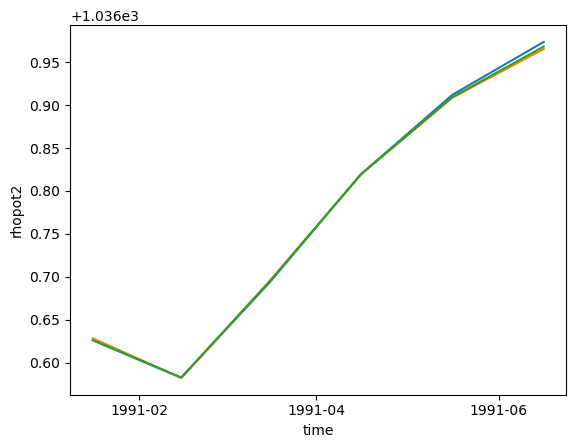

In [19]:
(σ2_1m_6months_shelf_mean).plot()
(σ2_5m_6months_shelf_mean).plot()
(σ2_1m_winds_6months_shelf_mean).plot()


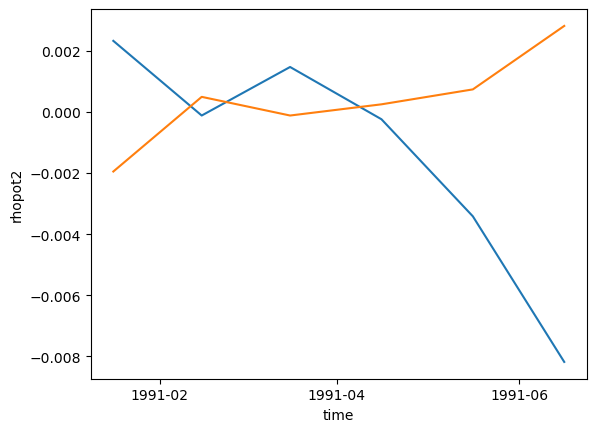

In [20]:
(σ2_5m_6months_shelf_mean-σ2_1m_6months_shelf_mean).plot()
(σ2_1m_winds_6months_shelf_mean-σ2_5m_6months_shelf_mean).plot()


In [21]:
#MOM5 delta salinity
MOM5_S5m_6months_shelf = MOM5_S5m_6months.weighted(area_t_shelf.fillna(0)).mean(('xt_ocean','yt_ocean'))
MOM5_S1m_6months_shelf = MOM5_S1m_6months_into5.weighted(area_t_shelf.fillna(0)).mean(('xt_ocean','yt_ocean'))


#MOM5 delta σ2
MOM5_σ0_5m_6months_shelf = MOM5_σ0_5m_6months.weighted(area_t_shelf.fillna(0)).mean(('xt_ocean','yt_ocean'))
MOM5_σ0_1m_6months_shelf = MOM5_σ0_1m_6months_into5.weighted(area_t_shelf.fillna(0)).mean(('xt_ocean','yt_ocean'))


In [22]:
zcoord_MOM6=np.tile(S5m_6months_shelf.z_l,(90,1))
zcoord_MOM5=np.tile(MOM5_S5m_6months_shelf.st_ocean,(90,1))

Isobath binning

In [23]:
#importing ocean depths
MOM5_bath= cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'ht', session, n=1)
MOM6_bath= cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'deptho', session, n=1)


#masking off shelf
MOM5_bath_shelf, shelf_mask_MOM5 = shelf_mask_isobath_MOM5(MOM5_bath)
MOM6_bath_shelf = shelf_mask_isobath(MOM6_bath, 1000, '01', output_mask=False)
MOM6_bath_shelf = MOM6_bath_shelf.where(MOM6_bath_shelf!=0)

#loading
MOM5_bath_shelf.load()
MOM6_bath_shelf.load()

#naming
MOM5_bath_shelf.name = 'Bathymetry'
MOM6_bath_shelf.name = 'Bathymetry'

In [24]:
from xhistogram.xarray import histogram

#the bathymetry bin edges are:
bins_bath = np.linspace(0,1000,31) #about every 50m depth

# MOM5_σ0_5m_6months_shelf - MOM5_σ0_1m_6months_shelf
#sigma for MOM5
deltaσ0_MOM5_bath = histogram(MOM5_bath_shelf, 
                          bins = bins_bath , 
                          dim = ['xt_ocean','yt_ocean'],
                          weights = ((MOM5_σ0_5m_6months - MOM5_σ0_1m_6months_into5)*area_t_shelf.fillna(0)).rename('deltaSigma'))/\
histogram(MOM5_bath_shelf, 
                          bins = bins_bath, 
                          dim = ['xt_ocean','yt_ocean'],
                          weights = area_t_shelf.fillna(0))

deltaσ0_MOM5_bath['st_ocean']=MOM5_σ0_5m_6months_shelf.st_ocean
deltaσ0_MOM5_bath['time']=MOM5_σ0_5m_6months_shelf.time




# #sigma for MOM6
deltaσ2_MOM6_bath = histogram(MOM6_bath_shelf, 
                          bins = bins_bath , 
                          dim = ['xh','yh'],
                          weights = ((σ2_5m_6months - σ2_1m_6months_into5)*areacello_shelf.fillna(0)).rename('deltaSigma'))/\
histogram(MOM6_bath_shelf, 
                          bins = bins_bath, 
                          dim = ['xh','yh'],
                          weights = areacello_shelf.fillna(0))
deltaσ2_MOM6_bath['z_l'] = σ2_5m_6months_shelf.z_l
deltaσ2_MOM6_bath['time'] = σ2_5m_6months_shelf.time

# #sigma for MOM6 winds
deltaσ2_MOM6_bath_winds = histogram(MOM6_bath_shelf, 
                          bins = bins_bath , 
                          dim = ['xh','yh'],
                          weights = ((σ2_1m_winds_6months - σ2_1m_6months)*areacello_shelf.fillna(0)).rename('deltaSigma'))/\
histogram(MOM6_bath_shelf, 
                          bins = bins_bath, 
                          dim = ['xh','yh'],
                          weights = areacello_shelf.fillna(0))
deltaσ2_MOM6_bath['z_l'] = σ2_5m_6months_shelf.z_l
deltaσ2_MOM6_bath['time'] = σ2_5m_6months_shelf.time


#Salinity for MOM5
deltaS_MOM5_bath = histogram(MOM5_bath_shelf, 
                          bins = bins_bath , 
                          dim = ['xt_ocean','yt_ocean'],
                          weights = ((MOM5_S5m_6months - MOM5_S1m_6months_into5)*area_t_shelf.fillna(0)).rename('deltaSigma'))/\
histogram(MOM5_bath_shelf, 
                          bins = bins_bath, 
                          dim = ['xt_ocean','yt_ocean'],
                          weights = area_t_shelf.fillna(0))

deltaS_MOM5_bath['st_ocean']=MOM5_S5m_6months_shelf.st_ocean
deltaS_MOM5_bath['time']=MOM5_S5m_6months_shelf.time


#Salinity for MOM6
deltaS_MOM6_bath = histogram(MOM6_bath_shelf, 
                          bins = bins_bath , 
                          dim = ['xh','yh'],
                          weights = ((S5m_6months - S1m_6months_into5)*areacello_shelf.fillna(0)).rename('deltaSigma'))/\
histogram(MOM6_bath_shelf, 
                          bins = bins_bath, 
                          dim = ['xh','yh'],
                          weights = areacello_shelf.fillna(0))

deltaS_MOM6_bath['z_l']=S5m_6months_shelf.z_l
deltaS_MOM6_bath['time']=S5m_6months_shelf.time


#Salinity for MOM6 winds
deltaS_MOM6_bath_winds = histogram(MOM6_bath_shelf, 
                          bins = bins_bath , 
                          dim = ['xh','yh'],
                          weights = ((S1m_winds_6months - S1m_6months)*areacello_shelf.fillna(0)).rename('deltaSigma'))/\
histogram(MOM6_bath_shelf, 
                          bins = bins_bath, 
                          dim = ['xh','yh'],
                          weights = areacello_shelf.fillna(0))

deltaS_MOM6_bath_winds['z_l']=S1m_6months.z_l
deltaS_MOM6_bath_winds['time']=S1m_6months.time


Might also be useful to get a timesries of mean salinity onshore, and offshore

In [25]:
%%time
S1m_6months_offshore = S1m_6months_into5.sel(yh=slice(-90,-60)).where(areacello_shelf.fillna(0)==0).weighted(areacello.fillna(0)).mean(('xh','yh')).load()
S5m_6months_offshore = S5m_6months.sel(yh=slice(-90,-60)).where(areacello_shelf.fillna(0)==0).weighted(areacello.fillna(0)).mean(('xh','yh')).load()

σ2_1m_6months_offshore = σ2_1m_6months_into5.sel(yh=slice(-90,-60)).where(areacello_shelf.fillna(0)==0).weighted(areacello.fillna(0)).mean(('xh','yh')).load()
σ2_5m_6months_offshore = σ2_5m_6months.sel(yh=slice(-90,-60)).where(areacello_shelf.fillna(0)==0).weighted(areacello.fillna(0)).mean(('xh','yh')).load()

CPU times: user 2min 57s, sys: 1min 44s, total: 4min 42s
Wall time: 4min 31s


In [26]:
import matplotlib.ticker as mticker
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ht = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'ht', session, n=1).sel(yt_ocean=slice(-90,-50))


land_mask = (ht*0).fillna(1)

In [27]:
#average delta in 5m depth
delta_σ0_MOM5 = (MOM5_σ0_5m_6months - MOM5_σ0_1m_6months_into5).where(shelf_mask_MOM5==1).weighted(MOM5_dzt_5m_6months.sel(st_ocean=slice(0,20)).fillna(0)).\
mean('st_ocean').load()
delta_σ2_MOM6 = (σ2_5m_6months - σ2_1m_6months_into5).where(shelf_mask_MOM6==1).sel(z_l=slice(0,20)).weighted(vol_5m_6months.fillna(0)).\
mean('z_l').load()

delta_σ2_MOM6_winds = (σ2_1m_winds_6months - σ2_1m_6months).where(shelf_mask_MOM6==1).sel(z_l=slice(0,20)).weighted(vol_1m_6months.fillna(0)).\
mean('z_l').load()

Lets import also the SWMT on the shelf

In [28]:
import glob
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/sigma0_panan01/*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
P01_1dz=xr.open_mfdataset(gl, concat_dim='time',combine='nested')


gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/sigma0_panan01_5mtop/*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
P01_5dz=xr.open_mfdataset(gl, concat_dim='time',combine='nested')

import glob
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/sigma0_panan01_1mtop_direct/*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
P01_1dz_direct=xr.open_mfdataset(gl, concat_dim='time',combine='nested')

10 netcdf data files
10 netcdf data files
10 netcdf data files


In [29]:
SHeat_5dz_shelf, shelf_mask_MOM6 = shelf_mask_isobath(P01_5dz.binned_heat_transformation, 1000, '01', output_mask=True)
Ssalt_5dz_shelf = shelf_mask_isobath(P01_5dz.binned_salt_transformation, 1000, '01')


SHeat_1dz_shelf = shelf_mask_isobath(P01_1dz.binned_heat_transformation, 1000, '01')
Ssalt_1dz_shelf = shelf_mask_isobath(P01_1dz.binned_salt_transformation, 1000, '01')

ShelfWMT_1dz_3d = shelf_mask_isobath(Ssalt_1dz_shelf+SHeat_1dz_shelf,1000, '01')

SHeat_1dz_direct_shelf = shelf_mask_isobath(P01_1dz_direct.binned_heat_transformation, 1000, '01')
Ssalt_1dz_direct_shelf = shelf_mask_isobath(P01_1dz_direct.binned_salt_transformation, 1000, '01')





ShelfWMT_5dz = (SHeat_5dz_shelf+Ssalt_5dz_shelf).sum('xh').sum('yh')
ShelfWMT_1dz = (SHeat_1dz_shelf+Ssalt_1dz_shelf).sum('xh').sum('yh')
ShelfWMT_direct_1dz = (SHeat_1dz_direct_shelf+Ssalt_1dz_direct_shelf).sum('xh').sum('yh')

ShelfWMT_1dz.load()
ShelfWMT_5dz.load()
ShelfWMT_direct_1dz.load()


print('loaded SWMT in panan')

loaded SWMT in panan


In [30]:
#Overflow files for panan01

#full file
Overflow_P5mtop= xr.open_mfdataset('/home/156/wf4500/v45_wf4500/DSW_collaborative/Daily_mass_transports/panan01_5mtop/*')
Overflow_P1mtop= xr.open_mfdataset('/g/data/e14/cs6673/mom6_comparison/data_DSW/vol_transp_across_1000m_isobath_panan_01deg_jra55_ryf_1m_*')
Overflow_P1mtop_direct= xr.open_mfdataset('/home/156/wf4500/v45_wf4500/DSW_collaborative/Daily_mass_transports/panan01_1mtop_direct/*')

#contour sum, yearly mean
Overflowsum_P5mtop=Overflow_P5mtop.sum('contour_index').groupby('time.year').mean().isel(rho2_l=slice(None, None, -1))
Overflowsum_P1mtop=Overflow_P1mtop.sum('contour_index').isel(time=slice(0,120)).groupby('time.year').mean().isel(rho2_l=slice(None, None, -1))
Overflowsum_P1mtop_direct=Overflow_P1mtop_direct.sum('contour_index').isel(time=slice(0,120)).groupby('time.year').mean().isel(rho2_l=slice(None, None, -1))


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:f

In [31]:
Overflowsum_P1mtop.load()
Overflowsum_P5mtop.load()
Overflowsum_P1mtop_direct.load()
print('loaded Panan flow across isobath')

loaded Panan flow across isobath


In [32]:
σ2_DSW_1m_mindens = 37.18
σ2_DSW_1m_maxdens = 37.28

In [33]:
#DSW filteres series
ShelfWMT_1dz_DSW=ShelfWMT_1dz.where(ShelfWMT_1dz.isopycnal_bins>=σ2_DSW_1m_mindens).\
where(ShelfWMT_1dz.isopycnal_bins<=σ2_DSW_1m_maxdens)

ShelfWMT_5dz_DSW=ShelfWMT_5dz.where(ShelfWMT_5dz.isopycnal_bins>=σ2_DSW_1m_mindens).\
where(ShelfWMT_5dz.isopycnal_bins<=σ2_DSW_1m_maxdens)


ShelfWMT_1dz_direct_DSW=ShelfWMT_direct_1dz.where(ShelfWMT_direct_1dz.isopycnal_bins>=σ2_DSW_1m_mindens).\
where(ShelfWMT_direct_1dz.isopycnal_bins<=σ2_DSW_1m_maxdens)


Calculating the mass transports across Isobath

In [34]:
lat_slice=slice(-90,-55)
depth_slice_20m = slice(0,50)


In [35]:
#getting the contour
ds_contour = xr.open_dataset(
    '/home/142/cs6673/work/mom6_comparison/Antarctic_slope_contours/' +
    'Antarctic_slope_contour_1000m_MOM6_01deg.nc')

# load data and rename coordinates to general x/y to be able to multiply them
mask_y_transport = ds_contour.mask_y_transport.rename(
    {'yq': 'y', 'xh': 'x'})
mask_x_transport = ds_contour.mask_x_transport.rename(
    {'yh': 'y', 'xq': 'x'})
mask_y_transport_numbered = ds_contour.mask_y_transport_numbered.rename(
    {'yq': 'y', 'xh': 'x'})
mask_x_transport_numbered = ds_contour.mask_x_transport_numbered.rename(
    {'yh': 'y', 'xq': 'x'})

# number of points along contour:
num_points = int(np.maximum(
    np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))


# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y', 'x'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y', 'x'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)

In [36]:
%%time

### 1m ###
u_MOM6_1m = cc.querying.getvar('panan01_1mtop_daily', 'uo', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).\
mean('time').sel(z_l_sub01=depth_slice_20m).rename({'z_l_sub01':'z_l'}).load()
v_MOM6_1m = cc.querying.getvar('panan01_1mtop_daily', 'vo', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yq=lat_slice).isel(time=slice(0,31)).\
mean('time').sel(z_l_sub01=depth_slice_20m).rename({'z_l_sub01':'z_l'}).load()



rho0_MOM6_1m_x = (cc.querying.getvar('panan01_1mtop_daily', 'rhopot0', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)).interp(xh=u_MOM6_1m.xq).drop('xh').load() 
rho0_MOM6_1m_y = (cc.querying.getvar('panan01_1mtop_daily', 'rhopot0', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)).interp(yh=v_MOM6_1m.yq).drop('yh').load() 


umo_MOM6_1m = (cc.querying.getvar('panan01_1mtop_daily', 'umo', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m) / rho0_MOM6_1m_x).load() #m3/s

vmo_MOM6_1m = (cc.querying.getvar('panan01_1mtop_daily', 'vmo', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yq=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m) / rho0_MOM6_1m_y).load() #m3/s



### 5m ###
u_MOM6_5m = cc.querying.getvar('panan01_5mtop_daily', 'uo', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).\
mean('time').sel(z_l_sub01=depth_slice_20m).rename({'z_l_sub01':'z_l'}).load()
v_MOM6_5m = cc.querying.getvar('panan01_5mtop_daily', 'vo', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yq=lat_slice).isel(time=slice(0,31)).\
mean('time').sel(z_l_sub01=depth_slice_20m).rename({'z_l_sub01':'z_l'}).load()


rho_MOM6_5m_x = (cc.querying.getvar('panan01_5mtop_daily', 'rhopot0', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)).interp(xh=u_MOM6_5m.xq).drop('xh').load() #m3/s
rho_MOM6_5m_y = (cc.querying.getvar('panan01_5mtop_daily', 'rhopot0', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)).interp(yh=v_MOM6_5m.yq).drop('yh').load() #m3/s


umo_MOM6_5m = (cc.querying.getvar('panan01_5mtop_daily', 'umo', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)/rho_MOM6_5m_x ).load() #m3/s

vmo_MOM6_5m = (cc.querying.getvar('panan01_5mtop_daily', 'vmo', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yq=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)/rho_MOM6_5m_y ).load() #m3/s



CPU times: user 1min 28s, sys: 15.9 s, total: 1min 44s
Wall time: 2min 2s


In [37]:
%%time

umo_session = cc.database.create_session('/home/156/wf4500/databases/access/DIRECT_rerun_umo.db')

### 1m winds###
### 1m ###
u_MOM6_1m_winds = cc.querying.getvar('mom6-panan', 'uo',umo_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).\
mean('time').sel(z_l_sub01=depth_slice_20m).rename({'z_l_sub01':'z_l'}).load()
v_MOM6_1m_winds = cc.querying.getvar('mom6-panan', 'vo', umo_session, n=31,frequency='1 daily',chunks = {})\
.sel(yq=lat_slice).isel(time=slice(0,31)).\
mean('time').sel(z_l_sub01=depth_slice_20m).rename({'z_l_sub01':'z_l'}).load()



rho0_MOM6_1m_winds_x = (cc.querying.getvar('mom6-panan', 'rhopot0', umo_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)).interp(xh=u_MOM6_1m_winds.xq).drop('xh').load() 
rho0_MOM6_1m_winds_y = (cc.querying.getvar('mom6-panan', 'rhopot0', umo_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)).interp(yh=v_MOM6_1m_winds.yq).drop('yh').load() 


umo_MOM6_1m_winds = (cc.querying.getvar('mom6-panan', 'umo', umo_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m) / rho0_MOM6_1m_winds_x).load() #m3/s

vmo_MOM6_1m_winds = (cc.querying.getvar('mom6-panan', 'vmo', umo_session, n=31,frequency='1 daily',chunks = {})\
.sel(yq=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m) / rho0_MOM6_1m_winds_y).load() #m3/s




CPU times: user 39.8 s, sys: 7.21 s, total: 47 s
Wall time: 48.5 s


In [38]:
#for MOM6_1m
# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (umo_MOM6_1m.rename({'yh':'y','xq':'x'})*mask_x_transport)\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (vmo_MOM6_1m.rename({'yq':'y','xh':'x'})*mask_y_transport)\
                    .stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

MOM6_vol_trans_across_contour_1m = xr.concat((x_transport_1d_i, y_transport_1d_i), dim='contour_index').sum('contour_index')

del x_transport_1d_i, y_transport_1d_i

#for MOM6_5m
# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (umo_MOM6_5m.rename({'yh':'y','xq':'x'})*mask_x_transport)\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (vmo_MOM6_5m.rename({'yq':'y','xh':'x'})*mask_y_transport)\
.stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

MOM6_vol_trans_across_contour_5m = xr.concat((x_transport_1d_i, y_transport_1d_i), dim='contour_index').sum('contour_index')

del x_transport_1d_i, y_transport_1d_i

#for MOM6_1m_winds
# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (umo_MOM6_1m_winds.rename({'yh':'y','xq':'x'})*mask_x_transport)\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (vmo_MOM6_1m_winds.rename({'yq':'y','xh':'x'})*mask_y_transport)\
                    .stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

MOM6_vol_trans_across_contour_1m_winds = xr.concat((x_transport_1d_i, y_transport_1d_i), dim='contour_index').sum('contour_index')



In [39]:
##### getting the mean zonal and meridional transport across the isobath
# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (umo_MOM6_1m.rename({'yh':'y','xq':'x'}))\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (vmo_MOM6_1m.rename({'yq':'y','xh':'x'}))\
                    .stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

MOM6_U_transport_1m = x_transport_1d_i.sum('contour_index')
MOM6_V_transport_1m = y_transport_1d_i.sum('contour_index')

del x_transport_1d_i, y_transport_1d_i


#for MOM6_5m
# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (umo_MOM6_5m.rename({'yh':'y','xq':'x'}))\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (vmo_MOM6_5m.rename({'yq':'y','xh':'x'}))\
.stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)


MOM6_U_transport_5m = x_transport_1d_i.sum('contour_index')
MOM6_V_transport_5m = y_transport_1d_i.sum('contour_index')
del x_transport_1d_i, y_transport_1d_i


# 1m_winds
x_transport_1d_i = (umo_MOM6_1m_winds.rename({'yh':'y','xq':'x'}))\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (vmo_MOM6_1m_winds.rename({'yq':'y','xh':'x'}))\
                    .stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

MOM6_U_transport_1m_winds = x_transport_1d_i.sum('contour_index')
MOM6_V_transport_1m_winds = y_transport_1d_i.sum('contour_index')

In [40]:
#Standardizing surface grid
MOM6_vol_trans_across_contour_1m_into5 = MOM6_vol_trans_across_contour_5m.copy()
MOM6_vol_trans_across_contour_1m_into5[0] = MOM6_vol_trans_across_contour_1m[0:4].sum('z_l')
MOM6_vol_trans_across_contour_1m_into5[1:] = MOM6_vol_trans_across_contour_1m[4:].values

MOM6_vol_trans_across_contour_1m_winds_into5 = MOM6_vol_trans_across_contour_5m.copy()
MOM6_vol_trans_across_contour_1m_winds_into5[0] = MOM6_vol_trans_across_contour_1m_winds[0:4].sum('z_l')
MOM6_vol_trans_across_contour_1m_winds_into5[1:] = MOM6_vol_trans_across_contour_1m_winds[4:].values


MOM6_Transport_1m_5mdepth = np.round((MOM6_vol_trans_across_contour_1m_into5*1e-6).\
                                isel(z_l=0).values,2)

MOM6_Transport_5m_5mdepth = np.round((MOM6_vol_trans_across_contour_5m*1e-6).\
                                isel(z_l=0).values,2)

MOM6_Transport_1m_winds_5mdepth = np.round((MOM6_vol_trans_across_contour_1m_winds_into5*1e-6).\
                                isel(z_l=0).values,2)

MOM6_Transport_1m_5mdepth ,MOM6_Transport_5m_5mdepth , MOM6_Transport_1m_winds_5mdepth 

(-0.94, -0.98, -0.97)

# Figure 5

In [41]:
figpath='/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/figs/'

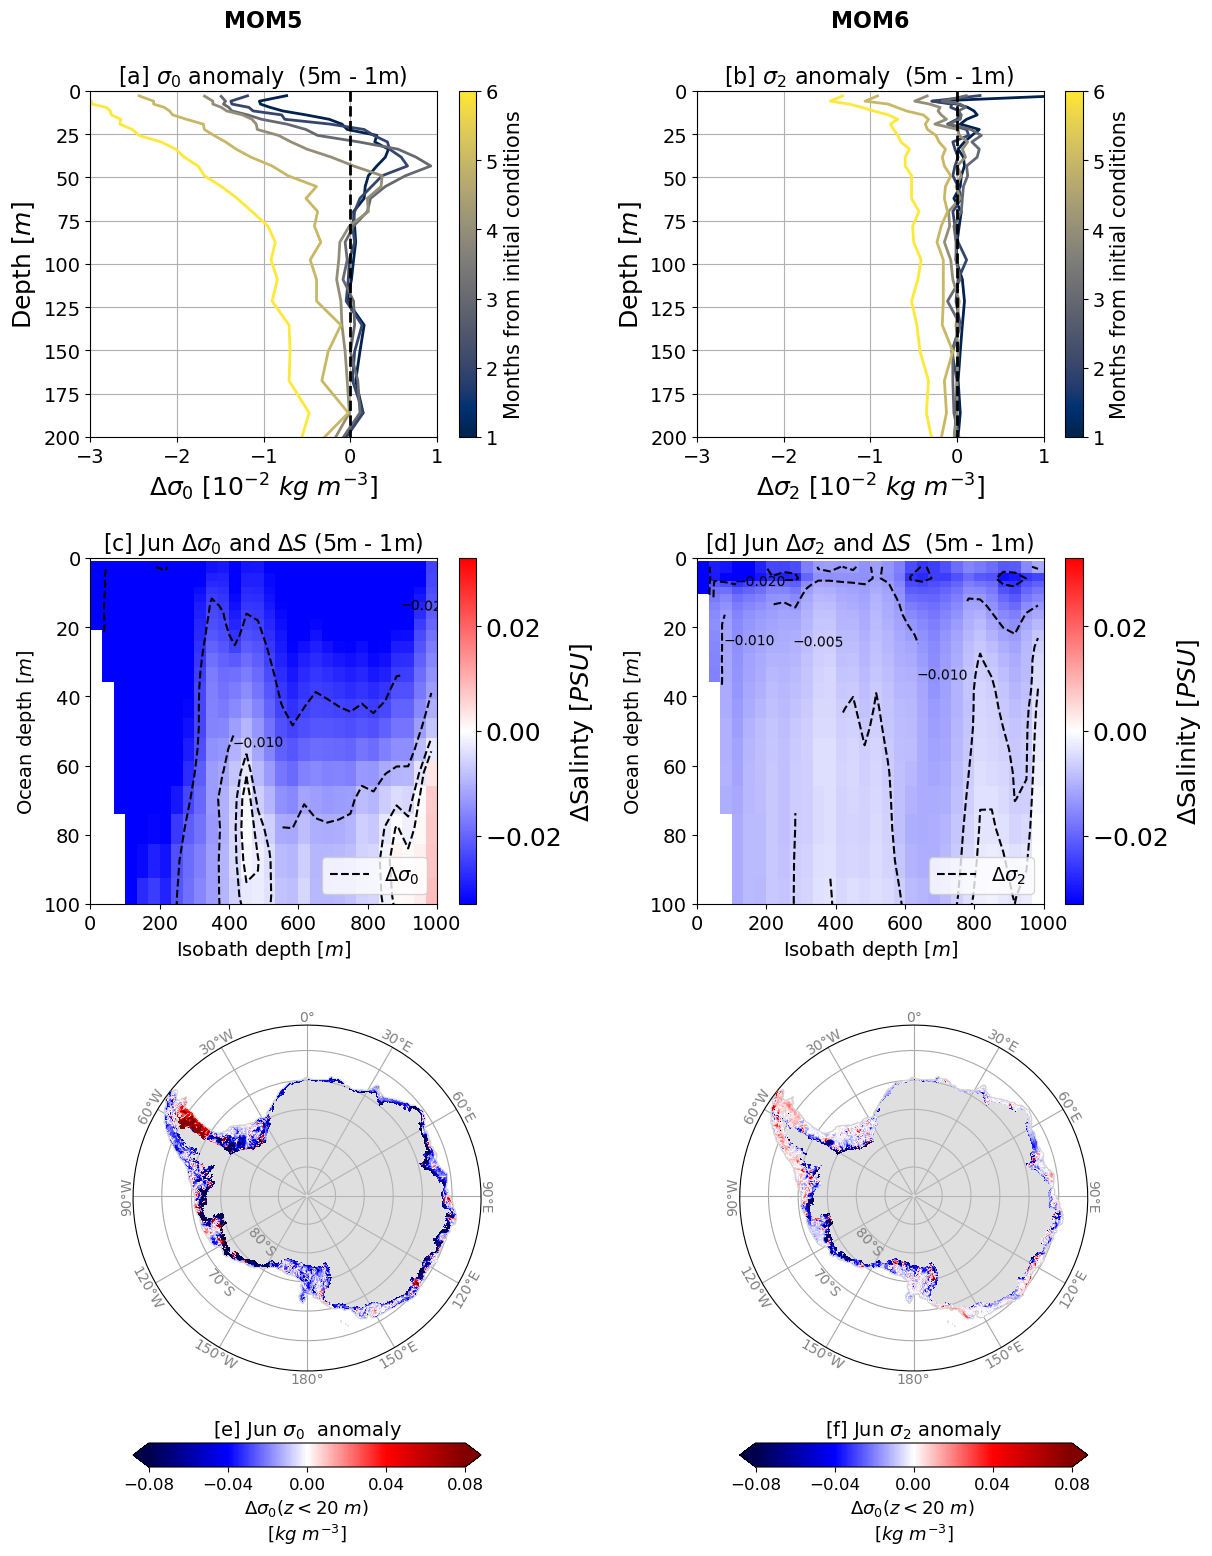

In [42]:
#parameters for the multiline plot
NTIME= 6 ; #number of instances in the time dimension, same unit as the time dimention (here days)
yint = np.arange(1, NTIME+1, 1) 
colors = plt.cm.cividis(np.linspace(0,1,NTIME+1))

#Daily multiline plot for the first month.
figure = plt.figure(num = 1, figsize = (13, 16))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.35)

plt.subplot(3,2,1)
lc00 = multiline((MOM5_σ0_5m_6months_shelf - MOM5_σ0_1m_6months_shelf).isel(time=slice(0,NTIME))*1e2,\
               zcoord_MOM5[0:NTIME,:], yint, cmap='cividis', lw=2)
plt.plot([0,0],[0,200],linestyle='--',linewidth=2,color='black')
plt.ylim((200,0)); 
plt.ylabel(r'Depth [$m$]', fontsize = 18)
plt.xlabel(r'$\Delta\sigma_0$ [$10^{-2}\ kg\ m^{-3}$]', fontsize=18)
axcb00 = figure.colorbar(lc00,ticks=np.arange(0,NTIME+1,int(NTIME/5)))
axcb00.ax.tick_params(labelsize=14)
axcb00.ax.set_ylabel(ylabel='Months from initial conditions',size=15)
plt.title(r'$\bf{MOM5}$' +' \n \n' + r'[a] $\sigma_0$ anomaly  (5m - 1m) ',fontsize=16);
plt.grid('minor'); plt.xticks(ticks=[-3, -2, -1, 0 ,1],fontsize=14);
plt.yticks(fontsize=14)
plt.xlim(-.03e2,.01e2)

plt.subplot(3,2,2)
lc0 = multiline((σ2_5m_6months_shelf - σ2_1m_6months_shelf).isel(time=slice(0,NTIME))*1e2,\
               zcoord_MOM6[0:NTIME,:], yint, cmap='cividis', lw=2)
plt.plot([0,0],[0,200],linestyle='--',linewidth=2,color='black')
plt.ylim((200,0)); 
plt.ylabel(r'Depth [$m$]', fontsize = 18)
plt.xlabel(r'$\Delta\sigma_2$ [$10^{-2}\ kg\ m^{-3}$]', fontsize=18)
axcb0 = figure.colorbar(lc0,ticks=np.arange(0,NTIME+1,int(NTIME/5)))
axcb0.ax.tick_params(labelsize=14)
axcb0.ax.set_ylabel(ylabel='Months from initial conditions',size=15)
plt.title(r'$\bf{MOM6}$' +' \n \n' + r'[b] $\sigma_2$ anomaly  (5m - 1m) ',fontsize=16);
plt.grid('minor'); plt.xticks([-3, -2, -1, 0 ,1],fontsize=14);
plt.yticks(fontsize=14)
plt.xlim(-.03e2,.01e2)





### isobath binned plots

dens_levels=[-.02,-.05,-.01,-.005, -.003]
normdens=0.08
normsal=0.033
monthind=5

plt.subplot(3,2,3)
MOM5_SPLOT = deltaS_MOM5_bath.isel(time=monthind).plot(x='Bathymetry_bin',vmin=-normsal,vmax=normsal,cmap='bwr',add_colorbar=False)
MOM5_SIGMAPLOT = deltaσ0_MOM5_bath.isel(time=monthind).plot.contour(x='Bathymetry_bin',levels=dens_levels,colors='k')
plt.plot([-1,-1],[-1,-1],linestyle='--',color='black',label=r'$\Delta\sigma_0$')
plt.clabel(MOM5_SIGMAPLOT)
plt.ylim(100,0); plt.xlim(0,1000)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel(r'Isobath depth [$m$]',fontsize=14)
plt.ylabel(r'Ocean depth [$m$]',fontsize=14)
plt.title(r'[c] Jun $\Delta \sigma_0$ and $\Delta S$ (5m - 1m) ',fontsize=16)
cbar0 = plt.colorbar(MOM5_SPLOT)
cbar0.ax.tick_params(labelsize=18) 
cbar0.ax.set_ylabel(r'$\Delta $Salinty [$PSU$]',fontsize=18) 
plt.legend(fontsize=14,loc=4)

plt.subplot(3,2,4)
MOM6_SPLOT = deltaS_MOM6_bath.isel(time=monthind).plot(x='Bathymetry_bin',vmin=-normsal,vmax=normsal,cmap='bwr',add_colorbar=False)
MOM6_SIGMAPLOT = deltaσ2_MOM6_bath.isel(time=monthind).plot.contour(x='Bathymetry_bin',levels=dens_levels,colors='k')
plt.plot([-1,-1],[-1,-1],linestyle='--',color='black',label=r'$\Delta\sigma_2$')
plt.clabel(MOM6_SIGMAPLOT)
plt.ylim(100,0); plt.xlim(0,1000)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel(r'Isobath depth [$m$]',fontsize=14)
plt.ylabel(r'Ocean depth [$m$]',fontsize=14)
plt.title(r'[d] Jun $\Delta \sigma_2$ and $\Delta S$  (5m - 1m) ',fontsize=16)
cbar1 = plt.colorbar(MOM6_SPLOT)
cbar1.ax.tick_params(labelsize=18) 
cbar1.ax.set_ylabel(r'$\Delta $Salinity [$PSU$]',fontsize=18) 
plt.legend(fontsize=14,loc=4)



#makps of density anomaly in the upper 20m, MOM5
proj = ccrs.PlateCarree()


ax325 = plt.subplot(3,2,5, projection=ccrs.SouthPolarStereo())
ax325.set_extent([-180, 180, -90, -60], proj)
ax325.set_boundary(circle, transform=ax325.transAxes)

gl2 = ax325.gridlines(draw_labels=False, color='darkgray')
gl2.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
             '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
lat_lon_label = [-59.5, -58.7, -59.5, -58.5, -58.5, -59.2, -59.5, -59.2,
                 -59.5, -58.7, -58.7, -59.5]
rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
                              30, -150, 150, -30]):
    ax325.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
            horizontalalignment='center', verticalalignment='center',
            color='gray', fontsize=10, transform=proj)
for j in range(70, 90, 10):
    label = str(j) + '°S'
    ax325.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
            verticalalignment='center', color='gray', fontsize=10,
            transform=proj)


ax325.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='silver', levels=[0.5, 2],
            transform=proj, rasterized=True, zorder=2,alpha=0.5)

plt.contour(shelf_mask_MOM5.xt_ocean, shelf_mask_MOM5.yt_ocean, shelf_mask_MOM5.values,
            levels=[0, 1], colors = 'lightgray', linewidth=.7,
            transform=proj)

p325 = ax325.pcolormesh(delta_σ0_MOM5.xt_ocean, delta_σ0_MOM5.yt_ocean,
                   delta_σ0_MOM5.isel(time=monthind),\
                        vmin=-normdens,vmax=normdens,cmap='seismic'
                   , transform=proj,
                   rasterized=True, zorder=3)
pos = ax325.get_position()
cax = plt.axes([pos.xmin, pos.ymin-0.06,
                1*(pos.xmax-pos.xmin), 0.015])


cb325 = plt.colorbar(p325, orientation='horizontal', cax=cax, extend='both')
cb325.ax.tick_params(labelsize=12)
cb325.ax.set_xlabel(r'$\Delta \sigma_0 (z<20\ m)$ ' + '\n' +
                 r'[$kg\ m^{-3}$]',fontsize=13)
cb325.ax.set_xticks(ticks=[-normdens, -normdens/2, 0, normdens/2, normdens])
plt.title('[e] Jun ' + r'$\sigma_0$ ' +' anomaly',fontsize=14)








ax326 = plt.subplot(3,2,6, projection=ccrs.SouthPolarStereo())
ax326.set_extent([-180, 180, -90, -60], proj)
ax326.set_boundary(circle, transform=ax326.transAxes)

gl2 = ax326.gridlines(draw_labels=False, color='darkgray')
gl2.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
             '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
lat_lon_label = [-59.5, -58.7, -59.5, -58.5, -58.5, -59.2, -59.5, -59.2,
                 -59.5, -58.7, -58.7, -59.5]
rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
                              30, -150, 150, -30]):
    ax326.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
            horizontalalignment='center', verticalalignment='center',
            color='gray', fontsize=10, transform=proj)
for j in range(70, 90, 10):
    label = str(j) + '°S'
    ax326.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
            verticalalignment='center', color='gray', fontsize=10,
            transform=proj)


ax326.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='silver', levels=[0.5, 2],
            transform=proj, rasterized=True, zorder=2,alpha=0.5)

plt.contour(shelf_mask_MOM5.xt_ocean, shelf_mask_MOM5.yt_ocean, shelf_mask_MOM5.values,
            levels=[0, 1], colors = 'lightgray', linewidth=.7,
            transform=proj)

p326 = ax326.pcolormesh(delta_σ2_MOM6.xh, delta_σ2_MOM6.yh,
                   delta_σ2_MOM6.isel(time=monthind),\
                        vmin=-normdens,vmax=normdens,cmap='seismic'
                   , transform=proj,
                   rasterized=True, zorder=3)
pos = ax326.get_position()
cax = plt.axes([pos.xmin, pos.ymin-0.06,
                1*(pos.xmax-pos.xmin), 0.015])


cb326 = plt.colorbar(p326, orientation='horizontal', cax=cax, extend='both')
cb326.ax.tick_params(labelsize=12)
cb326.ax.set_xlabel(r'$\Delta \sigma_0 (z<20\ m)$ ' + '\n' +
                 r'[$kg\ m^{-3}$]',fontsize=13)
cb326.ax.set_xticks(ticks=[-normdens, -normdens/2, 0, normdens/2, normdens])
plt.title('[f] Jun ' + r'$\sigma_2$' +' anomaly',fontsize=14)


plt.savefig(figpath+'V13_Figure_5.png',dpi=300,bbox_inches='tight')
plt.savefig(figpath+'V13_Figure_5.pdf',dpi=300,bbox_inches='tight')

the same salininity and density signal seem to happen within 6 months of a run. More interestingly, the freshening/lightening seem to be concentrated in the zonal coasts.

# Figure 7

In [43]:
from matplotlib.patches import Polygon

In [44]:
#DSW definition polygon for MOM6
σ2_DSW_1m_mindens = 37.18
σ2_DSW_1m_maxdens = 37.28


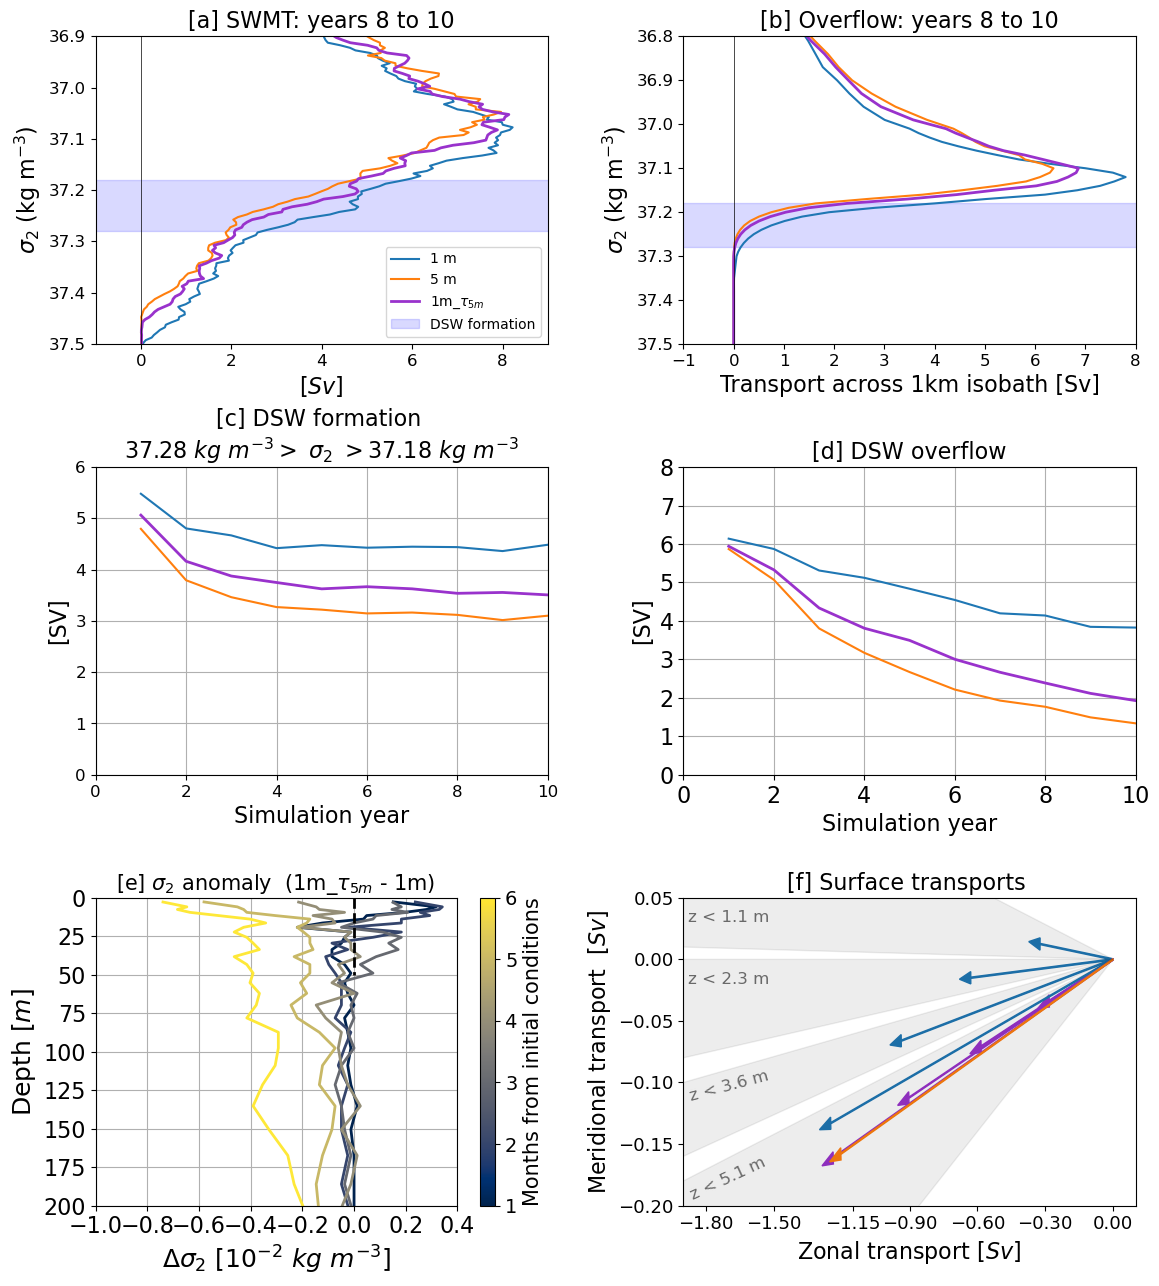

In [45]:
figure = plt.figure(num=1, figsize = (13,20))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)

yearind=slice(7,9)


windcolor='darkorchid'

ax_241 = plt.subplot(4,2,1)
MOM6_σ2_poly = Polygon([(-3,σ2_DSW_1m_mindens), (10,σ2_DSW_1m_mindens),(10,σ2_DSW_1m_maxdens), (-3,σ2_DSW_1m_maxdens),(-3,σ2_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')

plt.plot(ShelfWMT_1dz.isel(time=yearind).mean('time')/1e6, ShelfWMT_1dz.isopycnal_bins, color='tab:blue',label='1 m')
plt.plot(ShelfWMT_5dz.isel(time=yearind).mean('time')/1e6, ShelfWMT_5dz.isopycnal_bins, color='tab:orange',label='5 m')
plt.plot(ShelfWMT_direct_1dz.isel(time=yearind).mean('time')/1e6, ShelfWMT_1dz.isopycnal_bins, color=windcolor,label=r'1m_$\tau_{5 m}$',linewidth=2)
ax_241.add_patch(MOM6_σ2_poly)
plt.plot([0, 0], [36,37.5], 'k', linewidth=0.5)
plt.xlim(-1,9); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.ylim((37.5,36.9)); plt.legend(fontsize=10)
plt.ylabel(r'$\sigma_2$ (kg m$^{-3}$)', fontsize = 16)
plt.xlabel( r'[$Sv$]', fontsize=16)
plt.title(r"[a] SWMT: years 8 to 10",fontsize=16)



ax_242 = plt.subplot(4,2,2)
MOM6_σ2_poly = Polygon([(-3,σ2_DSW_1m_mindens), (10,σ2_DSW_1m_mindens),(10,σ2_DSW_1m_maxdens), (-3,σ2_DSW_1m_maxdens),(-3,σ2_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15)
plt.plot(Overflowsum_P1mtop.isel(year=yearind).mean('year').vol_trans_across_contour.cumsum('rho2_l')\
         ,Overflowsum_P1mtop.rho2_l-1000, color='tab:blue')
plt.plot(Overflowsum_P5mtop.isel(year=yearind).mean('year').vol_trans_across_contour.cumsum('rho2_l'),\
         Overflowsum_P5mtop.rho2_l-1000,color='tab:orange')
plt.plot(Overflowsum_P1mtop_direct.isel(year=yearind).mean('year').vol_trans_across_contour.cumsum('rho2_l')\
         ,Overflowsum_P1mtop_direct.rho2_l-1000, color=windcolor,linewidth=2)
ax_242.add_patch(MOM6_σ2_poly)
plt.plot([0, 0], [36,37.5], 'k', linewidth=0.5)
plt.xlim(-1,8); #plt.legend(fontsize=12)
plt.ylim((37.5,36.8)); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.ylabel(r'$\sigma_2$ (kg m$^{-3}$)', fontsize = 16)
plt.xlabel('Transport across 1km isobath [Sv]', fontsize=16)
plt.title(r"[b] Overflow: years 8 to 10",fontsize=16)






plt.subplot(4,2,3)
#SWMT:
(ShelfWMT_1dz_DSW.mean('isopycnal_bins')/1e6).plot(color='tab:blue',label=r"MOM5_1m")
(ShelfWMT_5dz_DSW.mean('isopycnal_bins')/1e6).plot(color='tab:orange',label=r"MOM5_5m")
(ShelfWMT_1dz_direct_DSW.mean('isopycnal_bins')/1e6).plot(color=windcolor,label=r"MOM5_1m",linewidth=2)
plt.xlim(1990.5,2000); plt.ylim(0,6)
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.grid(); plt.xticks(ticks=[1990,1992,1994,1996,1998,2000], labels=['0','2','4','6','8','10'])
plt.ylabel('[SV]', fontsize=16)
plt.title("[c] DSW formation \n" + str(σ2_DSW_1m_maxdens)+ r' $kg \ m^{-3}$'\
          + r'$> \ \sigma_2 \ >$' + str(σ2_DSW_1m_mindens) + r' $kg \ m^{-3}$',fontsize=16)
plt.xlabel('Simulation year', fontsize=16)


plt.subplot(4,2,4)
#overflow:
(Overflowsum_P1mtop.vol_trans_across_contour.cumsum('rho2_l').\
 where(Overflowsum_P1mtop.rho2_l>σ2_DSW_1m_mindens+1000).max('rho2_l'))\
.plot(color='tab:blue',label='MOM5_1m')
(Overflowsum_P5mtop.vol_trans_across_contour.cumsum('rho2_l').\
 where(Overflowsum_P5mtop.rho2_l>σ2_DSW_1m_mindens+1000).max('rho2_l'))\
.plot(color='tab:orange',label='MOM5_5m')
(Overflowsum_P1mtop_direct.vol_trans_across_contour.cumsum('rho2_l').\
 where(Overflowsum_P1mtop_direct.rho2_l>σ2_DSW_1m_mindens+1000).max('rho2_l'))\
.plot(color=windcolor,linewidth=2)
plt.xlim(1990.5,2000); plt.ylim(0,8)
plt.grid(); plt.xticks(ticks=[1990,1992,1994,1996,1998,2000], labels=['0','2','4','6','8','10'])
plt.ylabel('[SV]', fontsize=16); plt.xticks(fontsize=16); plt.yticks(fontsize=16);
plt.title("[d] DSW overflow",fontsize=16)
plt.xlabel('Simulation year', fontsize=16)


plt.subplot(4,2,5)
lc0 = multiline((σ2_1m_winds_6months_shelf - σ2_1m_6months_shelf).isel(time=slice(0,NTIME))*1e2,\
               zcoord_MOM6[0:NTIME,:], yint, cmap='cividis', lw=2)
plt.plot([0,0],[0,50],linestyle='--',linewidth=2,color='black')
plt.ylim((200,0)); 
plt.ylabel(r'Depth [$m$]', fontsize = 18)
plt.xlabel(r'$\Delta \sigma_2$ [$10^{-2} \ kg\ m^{-3}$]', fontsize=18)
axcb0 = figure.colorbar(lc0,ticks=np.arange(0,NTIME+1,int(NTIME/5)))
axcb0.ax.tick_params(labelsize=14)
axcb0.ax.set_ylabel(ylabel='Months from initial conditions',size=15)
plt.title(r'[e] $\sigma_2$ anomaly  (1m_$\tau_{5m}$ - 1m) ',fontsize=15);
plt.grid('minor'); plt.xticks(fontsize=16);
plt.yticks(fontsize=16)
plt.xlim(-.01e2,.004e2)





### plots of mean transport, along the 1 KM isobath, in the top 10 m of each simulation


#5m polygons
MOM5_5m_poly = Polygon([(0,0), (-1.3,-.35),(-1.9,-.35), (-1.9,-.25)],color='black',edgecolor=None,alpha=0.07)
MOM6_5m_poly = Polygon([(0,0), (-1.5,-.35),(-1.9,-.35), (-1.9,-.18)],color='black',edgecolor=None,alpha=0.07)

#3 cells polygons (3.6 m)
MOM5_3m_poly = Polygon([(0,0), (-1.9,-.23),(-1.9,-.15), (0,0)],color='black',edgecolor=None,alpha=0.07)
MOM6_3m_poly = Polygon([(0,0), (-1.9,-.16),(-1.9,-.1), (0,0)],color='black',edgecolor=None,alpha=0.07)

#2 cells polygons (2.3 m)
MOM5_2m_poly = Polygon([(0,0), (-1.9,-.13),(-1.9,-.03), (0,0)],color='black',edgecolor=None,alpha=0.07)
MOM6_2m_poly = Polygon([(0,0), (-1.9,-.08),(-1.9,0), (0,0)],color='black',edgecolor=None,alpha=0.07)

#1 cell polygons (1.1 m)
MOM5_1m_poly = Polygon([(0,0), (-1.9,-.02),(-1.9,.18), (0,0)],color='black',edgecolor=None,alpha=0.07)
MOM6_1m_poly = Polygon([(0,0), (-1.9,0.01),(-1.9,.18), (0,0)],color='black',edgecolor=None,alpha=0.07)


################# MOM5 transports ###############################################


ax7 = plt.subplot(4,2,6)

### top cell
plt.arrow(0,0,MOM6_U_transport_1m.isel(z_l=slice(0,1)).sum('z_l')/1e6,\
          MOM6_V_transport_1m.isel(z_l=slice(0,1)).sum('z_l')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:blue')

plt.arrow(0,0,MOM6_U_transport_1m_winds.isel(z_l=slice(0,1)).sum('z_l')/1e6,\
          MOM6_V_transport_1m_winds.isel(z_l=slice(0,1)).sum('z_l')/1e6,\
          head_width=1e-2,head_length=5e-2,color=windcolor)

### top 2 cells
plt.arrow(0,0,MOM6_U_transport_1m.isel(z_l=slice(0,2)).sum('z_l')/1e6,\
          MOM6_V_transport_1m.isel(z_l=slice(0,2)).sum('z_l')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:blue')

plt.arrow(0,0,MOM6_U_transport_1m_winds.isel(z_l=slice(0,2)).sum('z_l')/1e6,\
          MOM6_V_transport_1m_winds.isel(z_l=slice(0,2)).sum('z_l')/1e6,\
          head_width=1e-2,head_length=5e-2,color=windcolor)

### top 3 cells
plt.arrow(0,0,MOM6_U_transport_1m.isel(z_l=slice(0,3)).sum('z_l')/1e6,\
          MOM6_V_transport_1m.isel(z_l=slice(0,3)).sum('z_l')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:blue')

plt.arrow(0,0,MOM6_U_transport_1m_winds.isel(z_l=slice(0,3)).sum('z_l')/1e6,\
          MOM6_V_transport_1m_winds.isel(z_l=slice(0,3)).sum('z_l')/1e6,\
          head_width=1e-2,head_length=5e-2,color=windcolor)

### top 5m 
plt.arrow(0,0,MOM6_U_transport_1m.isel(z_l=slice(0,4)).sum('z_l')/1e6,\
          MOM6_V_transport_1m.isel(z_l=slice(0,4)).sum('z_l')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:blue')

plt.arrow(0,0,MOM6_U_transport_1m_winds.isel(z_l=slice(0,4)).sum('z_l')/1e6,\
          MOM6_V_transport_1m_winds.isel(z_l=slice(0,4)).sum('z_l')/1e6,\
          head_width=1e-2,head_length=5e-2,color=windcolor)

# plt.text(-1.27,-.15,str(MOM6_Transport_1m_5mdepth) + ' Sv',color='tab:blue',\
#          rotation = 30,fontsize=12)

plt.arrow(0,0,MOM6_U_transport_5m.isel(z_l=0)/1e6,MOM6_V_transport_5m.isel(z_l=0)/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:orange')

# plt.text(-1.15,-.165,str(MOM6_Transport_5m_5mdepth) + ' Sv',color='tab:orange',\
#          rotation = 32,fontsize=12)

# plt.text(-1.1,-.185,str(MOM6_Transport_1m_winds_5mdepth) + ' Sv',color=windcolor,\
#          rotation = 32,fontsize=12)


ax7.add_patch(MOM6_5m_poly)
plt.text(-1.88, -0.195,r'z < 5.1 m ',rotation=25,color='dimgray',fontsize=12)

ax7.add_patch(MOM6_3m_poly)
plt.text(-1.88, -0.115,r'z < 3.6 m ',rotation=15,color='dimgray',fontsize=12)

ax7.add_patch(MOM6_2m_poly)
plt.text(-1.88, -0.02,r'z < 2.3 m ',  color='dimgray',fontsize=12)


ax7.add_patch(MOM6_1m_poly)
plt.text(-1.88, 0.03,r'z < 1.1 m ', color='dimgray',fontsize=12)

plt.title('[f] Surface transports ',fontsize=16)

plt.yticks(fontsize=13);
plt.xticks(ticks=[-1.8, -1.5, -1.15, -0.9, -0.6, -0.3, 0 ],fontsize=13);
plt.xlim(-1.9,.1)
plt.ylim(-.20,.05)
plt.xlabel(r'Zonal transport [$Sv$]', fontsize = 16)
plt.ylabel( r'Meridional transport  [$Sv$]', fontsize=16)

pos = ax7.get_position()
new_pos = [pos.x0, pos.y0, pos.width, pos.height]
ax7.set_position(new_pos)



plt.savefig(figpath+'V13_Figure_7.png',dpi=300,bbox_inches='tight')
plt.savefig(figpath+'V13_Figure_7.pdf',dpi=300,bbox_inches='tight')

_________
_________